In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline
plt.style.use("bmh")

# Yahoo

In [4]:
from datetime import datetime
start = pd.to_datetime("1900-01-01")

ticker_name = "^SP500TR"
# ticker_name = "^GSPC"

# end = pd.to_datetime("2019-01-01")
end = pd.to_datetime(datetime.now().date())
period = "1d"
snp500 = yf.download(ticker_name, start=start, end=end, interval=period)["Adj Close"].dropna()

start = snp500.index[0] if snp500.index[0] >= pd.to_datetime("1978-01-01") else pd.to_datetime("1978-01-01")
print("Rectified Start: ",start)

if start != snp500.index[0]:
    mask = (snp500.index >= start) & (snp500.index <= end)
    snp500 = snp500[mask]


snp500.head()


[*********************100%***********************]  1 of 1 completed
Rectified Start:  1988-01-04 00:00:00


Date
1988-01-04    256.019989
1988-01-05    258.769989
1988-01-06    259.029999
1988-01-07    261.209991
1988-01-08    243.550003
Name: Adj Close, dtype: float64

# Yield Curve Inversions Data

In [5]:
def custom_resampler(arraylike):
    return any(arraylike < 0)

resample_freq = "3M"

In [19]:
yield_curve_inv = pd.read_csv("T10Y2Y.csv")
yield_curve_inv["DATE"] = pd.to_datetime(yield_curve_inv["DATE"])
yield_curve_inv["T10Y2Y"] = yield_curve_inv["T10Y2Y"].replace(".",0.0).astype("float")

mask = (yield_curve_inv['DATE'] >= start) & (yield_curve_inv['DATE'] <= end)
yield_curve_inv = yield_curve_inv[mask]

yield_curve_inv.set_index("DATE", inplace=True, drop= True)

t = yield_curve_inv.resample(resample_freq).apply(custom_resampler)["T10Y2Y"]
yield_curve_inv = t[t == True].index.tolist()

yield_curve_inv[:5]

[Timestamp('1989-01-31 00:00:00'),
 Timestamp('1989-04-30 00:00:00'),
 Timestamp('1989-07-31 00:00:00'),
 Timestamp('1989-10-31 00:00:00'),
 Timestamp('1990-01-31 00:00:00')]

# Recessions

In [21]:
nber_recession = pd.read_csv("USREC.csv")
nber_recession["DATE"] = pd.to_datetime(nber_recession["DATE"])

mask = (nber_recession['DATE'] >= start) & (nber_recession['DATE'] <= end)
nber_recession = nber_recession[mask]

nber_recession.set_index("DATE", inplace=True, drop= True)
nber_recession = nber_recession[nber_recession["USREC"] == 1].index.tolist()
nber_recession[:5]

[Timestamp('1990-08-01 00:00:00'),
 Timestamp('1990-09-01 00:00:00'),
 Timestamp('1990-10-01 00:00:00'),
 Timestamp('1990-11-01 00:00:00'),
 Timestamp('1990-12-01 00:00:00')]

In [22]:
snp500 = np.log(snp500)
snp_min, snp_max = snp500.min(), snp500.max()

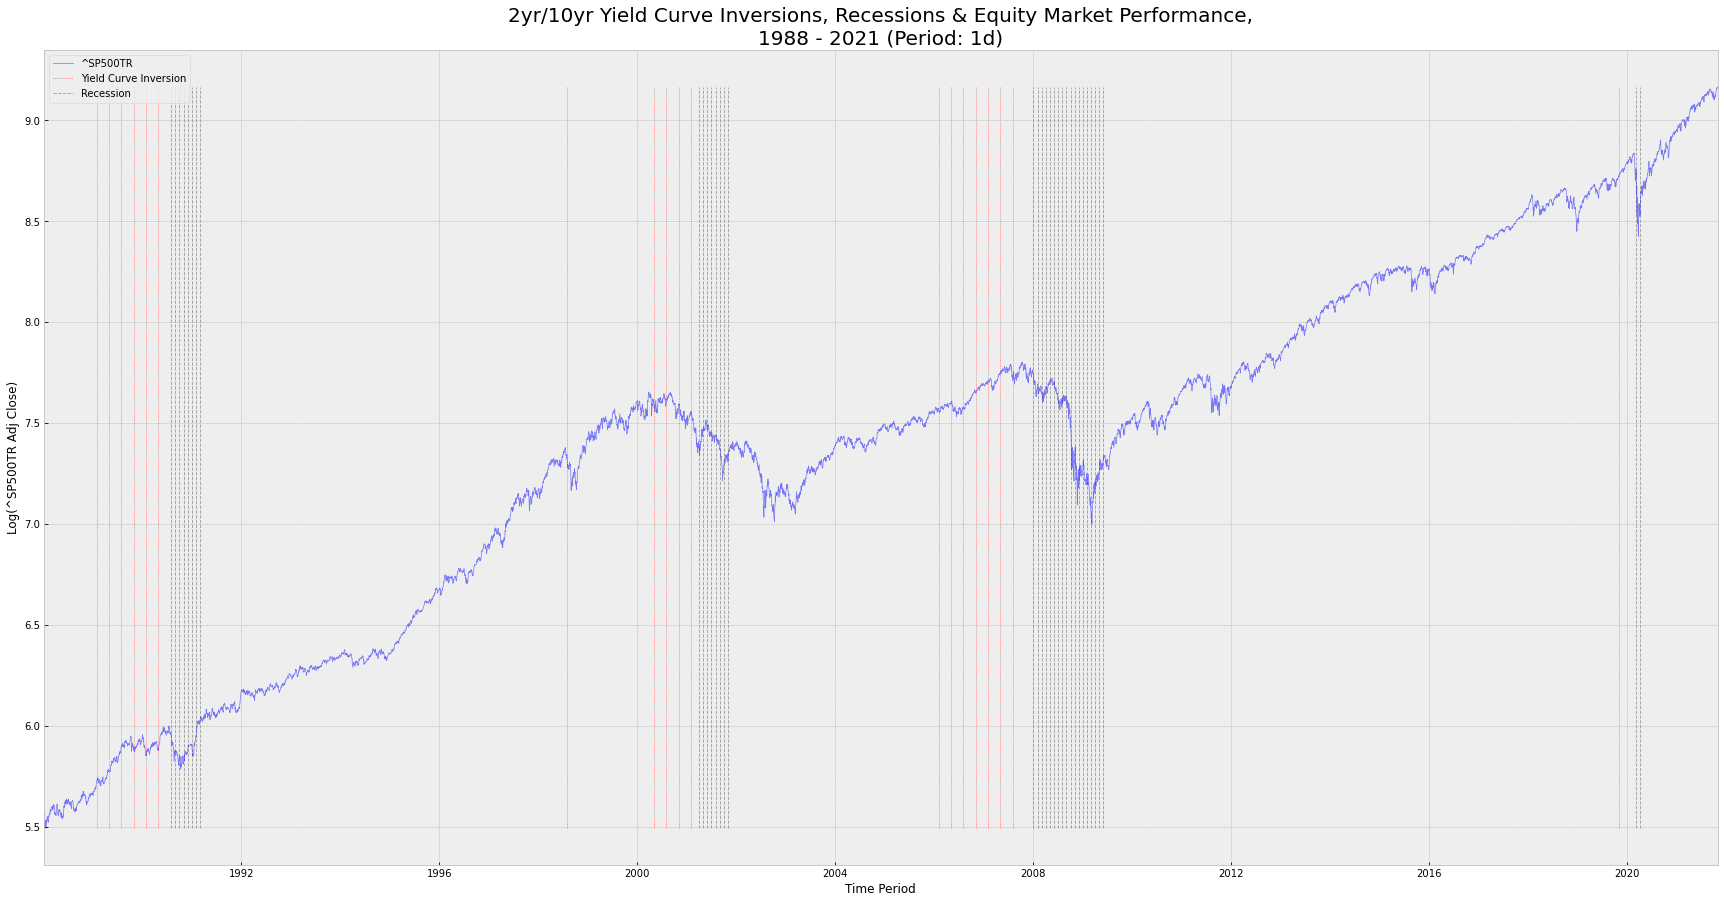

In [23]:
plt.figure().set_size_inches(30, 15,  forward=True)
plt.xlim((start,end))

# S&P 500 Total Returns
plt.plot(snp500, label = ticker_name, color = "blue", linewidth = 0.7, alpha = 0.5)

# Yield Curve Inversions
plt.vlines(yield_curve_inv, colors= "red", ymin= snp_min, ymax= snp_max, alpha = 0.7,
            linewidth = 0.7, linestyles = "dotted", label= "Yield Curve Inversion")

# Recession
plt.vlines(nber_recession, colors= "grey", ymin= snp_min, ymax= snp_max, alpha = 0.7,
            linewidth = 0.9, linestyles = "dashed" , label= "Recession")

plt.legend()
plt.xlabel("Time Period")
plt.ylabel("Log({tic} Adj Close)".format(tic = ticker_name))
plt.title("2yr/10yr Yield Curve Inversions, Recessions & Equity Market Performance,\n{start} - {end} (Period: {period})".format(start = start.year, end = end.year, period = period), fontsize = 20)
plt.savefig("yield_curve_vs_recession_data.png")

***
***